# Gett Product Analytics

## Description

[Gett](https://gett.com/intl/), previously known as GetTaxi, is an Israeli developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the _Order_ button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task we would like to investigate some matching metrics for orders that did not complete successfully, i.e., the customer didn't end up getting a car.

## Data

We have two data sets: `order` and `offers`. The `orders` data set contains the following columns:

- `order_datetime` - time of the order
- `order_longitude` - longitude of the order
- `order_latitude` - latitude of the order
- `m_order_eta` - time before order arrival
- `order_gk` - order number
- `order_status_key` - status, an enumeration consisting of the following mapping: `4` - cancelled by client, `9` - cancelled by system, i.e., a reject
- `is_driver_assigned_key` - whether a driver has been assigned
- `cancellation_time_in_seconds` - how many seconds passed before cancellation

## Task

Please complete the following tasks.

1. Build up a distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. Plot the average time to cancellation with and without driver, by hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Plot the distribution of average ETA by hours. How can this plot be explained?
5. **BONUS** Hexagons. Using the [h3](https://github.com/uber/h3-py) and [folium](https://python-visualization.github.io/folium/#:~:text=folium%20makes%20it%20easy%20to,as%20markers%20on%20the%20map.) packages, calculate how many size [8 hexes](https://h3geo.org/#/documentation/core-library/resolution-table) contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

## Read and explore the data sets

Before embarking on the quest to answer the presented questions, we will explore and pre-process the provided data sets in a bit of detail, so that we get more familiar with the type of data that we have and we set it in a format that would enable us to answer the questions more easily and more clearly.

We will use the Pandas library to load the CSVs into a dataframe structure. Over the years, Pandas has become the Python standard for manipulation and analysis of small to medium data sets. It has methods for reading and transforming data from many formats: HTML, JSON, Parquet, CSV, Excel, etc. At least a basic knowledge of Pandas is very often required for a data science position in any level, so investing some time to learn the library is worthwhile.


In [1]:
import pandas as pd

We use the `read_csv()` method to read the CSV with the orders (the notebook assumes that these are in the same directory). The `orders` variable is of type `pd.DataFrame` (you can verify that by running `type(orders)`) - an internal data structure managed by Pandas. It has the attribute `shape` which prints a tuple with the number of rows and columns. Below, we call the `sample()` method to print a sample of `n=10` rows.

In [2]:
orders = pd.read_csv(filepath_or_buffer="data_orders.csv")

In [3]:
orders.shape

(10716, 8)

In [4]:
# the random_state argument ensures that we get the same sample
# each time we call the method with the same arguments
orders.sample(n=10, random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
10309,00:29:14,-0.966062,51.454821,NaN,3000555146103,4,0,44.0
6705,01:28:45,-0.970472,51.456725,NaN,3000595870644,4,0,121.0
304,08:22:36,-0.916708,51.439852,NaN,3000627783633,9,0,NaN
9143,07:32:27,-0.955580,51.453493,1078.0,3000622140805,4,1,1017.0
10593,04:39:55,-0.946358,51.439779,NaN,3000554645524,4,0,121.0
8654,08:05:02,-0.967327,51.449395,598.0,3000592772077,4,1,48.0
3919,00:21:47,-0.971597,51.457574,NaN,3000624492441,4,0,180.0
4337,20:26:40,-0.971296,51.458115,NaN,3000628755869,4,0,104.0
6931,07:25:39,-0.942301,51.474812,NaN,3000628430595,4,0,44.0
967,13:41:31,-0.952194,51.444067,NaN,3000623591189,9,0,NaN


We repeat the same procedure for the `offers` CSV.

In [5]:
offers = pd.read_csv(filepath_or_buffer="data_offers.csv")

In [6]:
offers.shape

(334363, 2)

In [7]:
offers.sample(n=10, random_state=42)

,order_gk,offer_id
244971,3000627481054,300052086404
236783,3000631282042,300052342376
22714,3000624367715,300051909011
306983,3000557436646,300050769980
170256,3000588131807,300051201442
316173,3000629756224,300052250019
234398,3000625018320,300051967737
122107,3000629082264,300052196687
60909,3000588606991,300051225443
52998,3000629981908,300052274857


Next we would like to merge the two dataframes into one, for easier manipulation. Pandas has the `merge()` method for doing exactly that. It is similar to joining tables in SQL. We specify how we want the merge to be carried out (`inner`) and on which column should it occur (`order_gk`). Then, we print a sample of the merged dataframe.

In [8]:
df = orders.merge(right=offers, how="inner", on="order_gk")

In [9]:
df.sample(n=10, random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163
13008,03:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801
18189,07:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628


We may be able to do something to improve the data quality a bit. For example, the values in `order_status_key` and `is_driver_assigned_key` are not informative of the contents, but are rather just keys that point to some internal description. We could replace their values with more informative information, like replacing the `1`s in `is_driver_assigned_key` with the string `Yes` and the `0`s with the string `No`. Same can be done for the `order_status_key` column. Moreover, the names of the columns sound a bit technical, but we can modify them.

Remember, data science is very closely related to the business, so we need to make our presentations as friendly for non-technical folks as possible.

To achieve what we have just described we will use the [where](https://numpy.org/doc/stable/reference/generated/numpy.where.html) method in the Numpy library. While Numpy is more known for linear algebra operations, its usage will come in handy in this use case as well. The `where()` method is applied to a column in the Pandas dataframe, and takes three input arguments: a `condition` that can be evaluated, and two options `x` and `y` which are returned depending on the outcome of the condition.

In the process of applying the _where_ method, we will create two new columns with better names. Later, we will drop the old columns.

In [10]:
import numpy as np

df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

# the inplace argument tells Pandas to modify the calling dataframe object,
# instead of returning a new object as a result
df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

Lastly, the column name `order_datetime` is misleading, as it doesn't contain the date & time of the order, it shows only the time (we don't know the date range of the data). We can rename it to `order_time` to reflect that fact.

In [11]:
# we pass in a dict of old column names as keys and new column names as values
df = df.rename(columns={
    "order_datetime": "order_time"
})

In [12]:
df.sample(n=10, random_state=42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,223.0,300050725946,Yes,Client Cancelled
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,91.0,300052014519,No,Client Cancelled
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,68.0,300051458740,No,Client Cancelled
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,125.0,300052031394,No,Client Cancelled
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,11.0,300050671163,No,Client Cancelled
13008,03:03:45,-0.966745,51.453236,NaN,3000593295623,NaN,300051413313,No,System Reject
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,6.0,300051090742,No,Client Cancelled
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,NaN,300051125957,No,System Reject
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,113.0,300052078801,No,Client Cancelled
18189,07:52:29,-0.973793,51.458665,479.0,3000587781360,47.0,300051178628,Yes,Client Cancelled


At this point we are ready to start answering the questions, so let's go!

## Question 1
**Build up a distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?**

One, very straightforward and easy solution to solve this question is to use the [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method to group the dataframe by the `is_driver_assigned` and `order_status` columns, and then count the rows in each group, i.e., each combination of values for the grouping columns.

Since both are binary variables (have only two possible values), there are four possible combinations. The cell below prints the output of the proposed approach.

We observe high number of orders cancelled before a driver is assigned, implying that maybe customers have waited too long and have decided on an alternative for their transportation needs. We have `13435` orders cancelled by the client, and `9469` rejected by the system. There are `8360` client cancellations after a driver has been assigned, and only **four** which were rejected by the system, for some reason.

In [13]:
df.groupby(by=["is_driver_assigned", "order_status"])["order_gk"].count()

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

Another interesting approach to this question is to use pivot tables (for more information, see the Pandas [method](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) and this Wikipedia [article](https://en.wikipedia.org/wiki/Pivot_table)).

With this approach, we are essentially doing the same thing as the group-by operation, but in a different way. We specify columns that need to be pivoted, what column values should we present, and how to aggregate them.

Once the pivot table is created (variable `df_q1`) we call the `plot(...)` method on it to generate a bar plot, with legend, for better, visual overview.

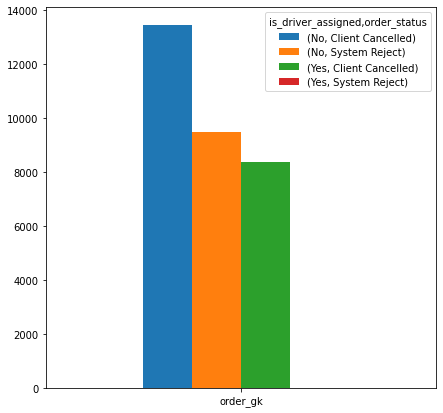

In [14]:
df_q1 = df.pivot_table(columns=["is_driver_assigned", "order_status"], values="order_gk", aggfunc="count")
_ = df_q1.plot(kind="bar", subplots=False, figsize=(7, 7), legend=True, rot=0)

In [15]:
# the structure of the pivot table is very similar to the group-by dataframe
df_q1

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

Both approaches solve the question, and give same results. Deciding on an approach is a matter of taste.

Pivot tables are a **must** for a data oriented position, as they are heavily used in Excel. If you ever encounter Excel in your job (and as a data scientist, chances are that you certainly will), knowledge of working with pivot tables will make your job much easier.

The group-by approach is more concise and clear, and comes more natural to a person who works with SQL and relational databases.

## Question 2
**Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?**

This question builds up upon the previous one by delving deeper into the analysis of failed orders. Rather than just plotting the distribution of fails by category (reason for cancellation, and the driver assignment), we want to know when these fails occur, and if there is some specific time period in the day when one category prevails over others.

The first step towards solving the question would be to extract the hour from the `order_time` column for easier manipulation. The way we do that is the following. The format of the `order_time` is `hh:mm:ss`. We turn that into a string by calling the `.str` on the `order_time` column, splitting it with  `:` as a delimiter and then apply a lambda function to return the first token of the split, i.e., the hour. We store this information into a new column, called `order_hour`.

In [16]:
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])

In [17]:
# print a small sample to make sure that the transformation is correct
df.sample(n=5, random_state=42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,223.0,300050725946,Yes,Client Cancelled,21
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,91.0,300052014519,No,Client Cancelled,10
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,68.0,300051458740,No,Client Cancelled,09
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,125.0,300052031394,No,Client Cancelled,02
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,11.0,300050671163,No,Client Cancelled,21


Next, we can plot the total number of failed orders per hour. We use a simple group-by operation on the order hour, and then count the `order_gk`. A very high number of failed orders is observed in the morning around 7-8 o'clock. This might point to the fact that the working day starts in those hours, so people are in higher need of transportation. The exact reason for such high number of failures can't be inferred from this plot, so let's continue to plot the same chart, but drilled further into the cause for the cancellation.

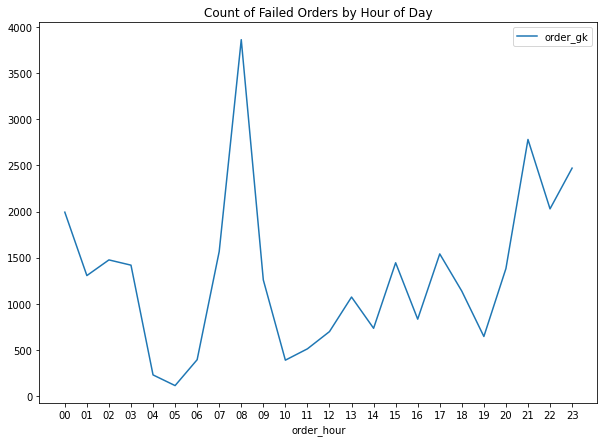

In [18]:
_ = df.groupby(by="order_hour")["order_gk"].count().plot(figsize=(10, 7),
                                                         legend=True,
                                                         xticks=range(0, 24),
                                                         title="Count of Failed Orders by Hour of Day")

As a first step towards a dataframe that contains such aggregated information we group-by by the order hour, the driver-assigned flag, and the order status, and then count the number of `order_gk`.

In [19]:
grouped_q2 = df.groupby(by=["order_hour", "is_driver_assigned", "order_status"])["order_gk"].count()
grouped_q2

order_hour  is_driver_assigned  order_status    
00          No                  Client Cancelled     957
                                System Reject        706
            Yes                 Client Cancelled     326
                                System Reject          4
01          No                  Client Cancelled     633
                                                    ... 
22          No                  System Reject        660
            Yes                 Client Cancelled     415
23          No                  Client Cancelled    1144
                                System Reject        883
            Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

The group-by operation results in the correct information. However, Pandas puts the group-by columns as indices in the resulting dataframe. To manipulate it easier, we can call the [reset_index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) to have the index columns as regular, data columns, and create a new, incrementing integer as an index.

We will create a multi-line plot, with the order hour on the horizontal axis, and multiple lines that count the number of orders per hour and per fail category. Then, we pivot the table around the order hour column, so that it can be plotted on the x-axis. We specify the driver-assigned flag and the order status as `columns` attributes, so that there is one line per combination of values, and then present the `order_gk` column as the `values` argument.

Moreover, we decorate the plot with a custom figure size, a title, and a `xticks` parameter.

Note that here we call the [pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) method and not [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot_table.html) as in the previous question.

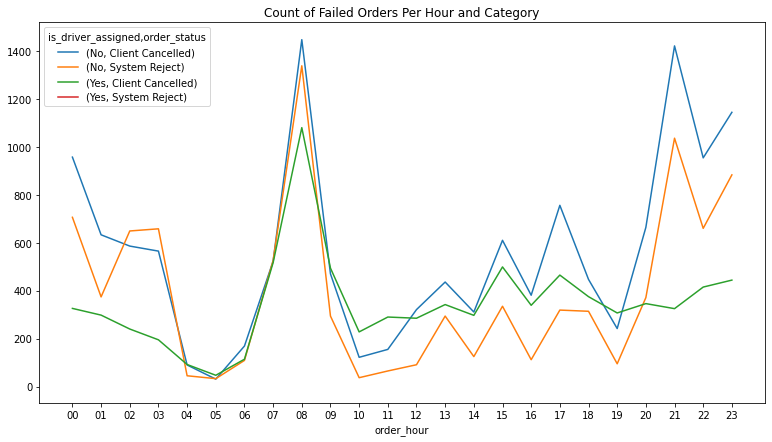

In [20]:
_ = grouped_q2.reset_index().pivot(index="order_hour",
                                   columns=["is_driver_assigned", "order_status"],
                                   values="order_gk").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Count of Failed Orders Per Hour and Category")

The four system rejects with assigned driver occurred around midnight (see the output of the grouped dataframe). The rest of the categories follow similar distribution, with the client cancellations with assigned driver having substantially lower count in the night hours.

## Question 3

**Plot the average time to cancellation with and without driver, by hour. Can we draw any conclusions from this plot?**

To solve this question we are going to take the same approach from the previous question.

First, we will group by the dataframe by the order hour and the driver-assignment flag. Then, we will aggregate the `cancellations_time_in_seconds` column with the function [mean](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mean.html). This will give us the required, aggregated information.

In [21]:
grouped_q3 = df.groupby(by=["order_hour", "is_driver_assigned"])["cancellations_time_in_seconds"].mean()
grouped_q3

order_hour  is_driver_assigned
00          No                    115.126437
            Yes                   276.082822
01          No                    100.593997
            Yes                   296.312081
02          No                    121.305461
            Yes                   301.466667
03          No                    129.182301
            Yes                   368.682051
04          No                    100.733333
            Yes                   245.250000
05          No                    102.838710
            Yes                   156.617021
06          No                    202.952663
            Yes                   225.508772
07          No                    141.177820
            Yes                   177.640232
08          No                    132.625432
            Yes                   172.896296
09          No                    138.014894
            Yes                   230.821862
10          No                     93.795082
            Yes         

Next, we call the `reset_index()` method to transform the grouping columns from indices into regular, data columns. We continue to chain the method calling on the resulting dataframe with the `pivot()` method, where we again specify grouping columns and the aggregated values. Lastly, we plot the pivoted dataframe, and add custom title, x-ticks, and a figure size for better visual presentation.

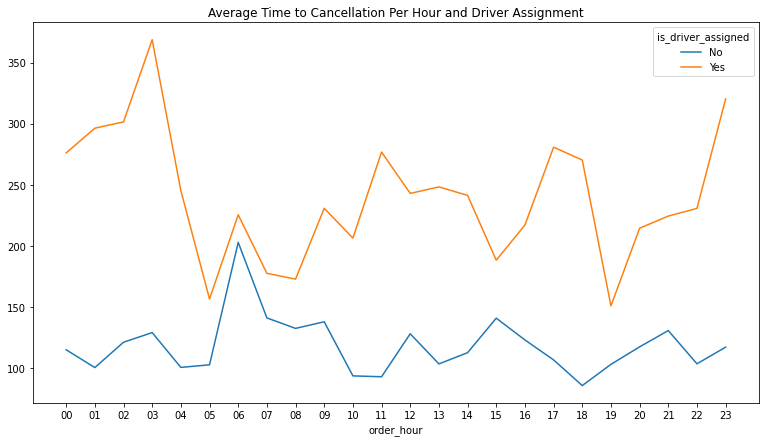

In [22]:
_ = grouped_q3.reset_index().pivot(index="order_hour",
                                   columns="is_driver_assigned",
                                   values="cancellations_time_in_seconds").plot(xticks=range(0, 24),
                                                                                figsize=(13, 7),
                                                                                title="Average Time to Cancellation Per Hour and Driver Assignment")

The average time to cancellation is higher on orders with an assigned driver, than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

## Question 4
**Plot the distribution of average ETA by hours. How can this plot be explained?**

The solution to this question is quite straightforward. We simply group-by the dataframe on the order hour, and aggregate the `m_order_eta` column with a mean function. Then, we plot the resulting dataframe. The result is in the cell immediately below. The line very closely matches the count of failed orders per hour, indicating that **the number of failed orders increases as the average waiting time of the client increases**.

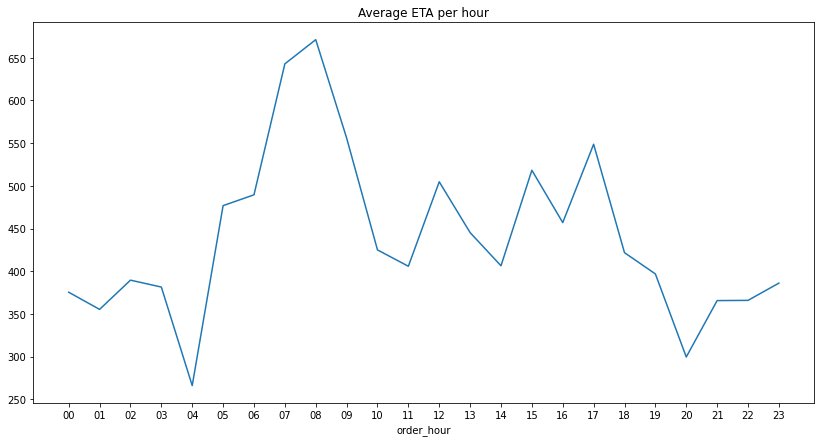

In [23]:
_ = df.groupby(by="order_hour")["m_order_eta"].mean().plot(figsize=(14, 7),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour")

## BONUS: Question 5

**Using the [h3](https://github.com/uber/h3-py) and [folium](https://python-visualization.github.io/folium/#:~:text=folium%20makes%20it%20easy%20to,as%20markers%20on%20the%20map.) packages, calculate how many size [8 hexes](https://h3geo.org/#/documentation/core-library/resolution-table) contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.**

`h3` is an open-source framework developed by Uber. At its core, it is a geospatial analysis tool that provides a hexagonal, hierarchical, spatial index to gain insights from large geospatial databases. `h3` covers the entire world with hexagons of different sizes. We can map the latitude and longitude attributes that we have in our data to a hexagon ID, an internal `h3` ID that points to a specific hexagon of a specific _resolution_ (8, as required in the question).

That will result in each order having a new column, that we'll call `hex_id`.
Next, what we want to do is to group by the data by the `hex_id`, and count the number of failed orders in it.

In [24]:
import h3
import folium

In [25]:
df["hex_id"] = df.apply(
    func=lambda row: h3.geo_to_h3(lat=row["origin_latitude"], lng=row["origin_longitude"], resolution=8), axis=1)

In [26]:
grouped_q5 = df.groupby(by="hex_id")["order_gk"].count()
grouped_q5.shape

(139,)

In [27]:
grouped_q5 = grouped_q5.reset_index()
grouped_q5.sample(n=5, random_state=42)

,hex_id,order_gk
135,88195d74d1fffff,1
66,88195d2a33fffff,12
31,88195d2941fffff,52
118,88195d2b5dfffff,31
42,88195d2961fffff,5


To find the number of hexes that contain 80% of the orders, we will apply a cumulative percentage operation over the `order_gk` count column in the `grouped_q5` dataframe. This consists of the following steps:

1. Sort the dataframe by the count.
2. Find the total number (sum) of failed orders.
3. Apply the method [cumsum](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html) to find the cumulative sum of the order-count column.
4. Divide by the total sum to generate percentages.
5. Filter to find the row that is closest to 80%.

In [28]:
grouped_q5 = grouped_q5.sort_values(by="order_gk")  # 1
total_orders = grouped_q5["order_gk"].sum()  # 2
grouped_q5["cum_sum"] = grouped_q5["order_gk"].cumsum()  # 3
grouped_q5["cum_perc"] = 100 * grouped_q5["cum_sum"] / total_orders  # 4
grouped_q5[grouped_q5["cum_perc"] <= 80]  # 5

,hex_id,order_gk,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.003198
135,88195d74d1fffff,1,2,0.006396
79,88195d2aebfffff,1,3,0.009594
11,88195d282bfffff,1,4,0.012793
122,88195d3993fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


There are 137 rows in the final output, and 139 rows in the original grouped dataframe, meaning that 137 hexagons contain around 80% of data, and only 2 hexagons contain the rest 20%!

Thus far we have solved the first part of the question, so we can move on to the second part, and plot the hexagons on a map.

As requested, we will use `folium` for drawing the map.

In [29]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this present the map best
                 tiles="cartodbpositron")

To be able to draw the hexagons, we need to transform them in a format that is readable by `folium`, and one solution for that is the `geojson` package, which contains methods for manipulation of formats (JSONs) that represent geographic objects. It is a bit specialized than JSON, in that it contains some complex objects, such as points, polygons, geometry collections, etc.

In the cell below we apply a custom `to_geojson` function that transforms the `hex_id` we have for each hexagon into a proper `geojson` object that can be read into `folium`. For each row (each order) we create a `geojson.Feature` object that stores transformed geometric boundaries for each hexagon. We collect all such objects into a `FeatureCollection` and dump it into a JSON-formatted string.

In [30]:
import json
import geojson


def to_geojson(row):
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_gk": row["order_gk"]})


geojsons = grouped_q5.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

To better visualise the hexagons, we are creating a colour map from `matplotlib`, and taking note of the minimum and maximum number of orders. Make sure to work here with the grouped dataframe, and not the original data set.

In [31]:
import matplotlib

colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = grouped_q5["order_gk"].max()
min_order_gk = grouped_q5["order_gk"].min()

Finally, we pass in the GeoJSON string and a lambda style function for it as input arguments into the `folium.GeoJson` constructor that creates a proper object that than gets added to the map. Lastly, we plot the map.

We suggest that you take some time and explore this question in depth, as there are a lot of moving parts and a lot of tiny details. Feel free to experiment with some of the parameters and see what kind of map you can produce!

In [32]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [33]:
map